# STDSR23 - Assignment-01

__Name:__ *Ivan*
__Surname:__ *Chernakov*
__Telegram alias:__ *@ivanchgram*
__Group number:__ *2*
# Quantile implementation
February 2023

## Assignment description

* Obtain the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)

* Select and implement one of the methods discussed in the paper, following good coding style and with appropriate comments. Your algorithm can be based on `BasicQuantileAlgorithm` class. In that case, your main implementation is in the `compute_quantile` function.
* Prepare a report that includes
    * A detailed explanation of the selected algorithm
    * A listing of the pros and cons of the chosen algorithm
* Test your implementation. More on that below in section `Test`.
* Submit Jupyter Notebook *.ipynb* to the Moodle

Note: Code style, comments, and overall organization of the report will be
taken into account in the grading process.


## Methods for MRL98 Algorithm.
### New, Merge, Collapse, Output

In [1]:
from pympler import asizeof
import sys
from typing import Tuple, Union, Any, List
import numpy as np

class Buffer:
    def __init__(self, k, w, label=False, seq=[], level=None):
        self.k = k
        self.w = w
        self.label = label
        self.sequence = seq
        self.level = level

def new(buffer, sequence):
    """
    Method for creating new buffer.
    :param buffer: Buffer
    :param sequence: List
    """
    length = len(sequence)

    if length < buffer.k:

        remains = int((buffer.k - length + 1) / 2)
        # If buffer is not full, fill it with pos. neg. infinity values.
        buffer.sequence = sequence[:] + [np.Inf] * remains + [np.NINF] * remains
    else:

        buffer.sequence = sequence[:buffer.k]

    buffer.label = True
    buffer.weight = 1

def merge(buffers):
    """
    Method for merging buffers.
    :param buffers: List
    :return: result_sequence, weights
    """

    # Calculate weights and offset via algorithm from paper.
    weights = sum([buffer.weight for buffer in buffers])
    offset = int((weights + 1) / 2 if weights % 2 == 1 else weights / 2)
    numberOfBuffers = len(buffers)
    k = buffers[0].k

    sequences = []
    for buffer in buffers:
        sequence = buffer.sequence.copy()
        sequence.sort()
        sequences.append(sequence)

    counter = 0
    result_sequence = []
    current_id = [0] * numberOfBuffers

    cur_values = [sequences[i][current_id[i]] for i in range(numberOfBuffers) if current_id[i] < k]

    i = 0

    while i < k:
        # Calculate position of current element.
        pos = i * weights + offset + (not weights % 2) * (i % 2)

        cur_values = [sequences[i][current_id[i]] for i in range(numberOfBuffers) if current_id[i] < k]
        # Find min value and its index.
        min_value = min(cur_values)
        min_index = cur_values.index(min_value)
        current_id[min_index] += 1
        # Update counter.
        counter += buffers[min_index].weight
        if counter >= pos:
            result_sequence.append(min_value)
            i += 1
    return result_sequence, weights

def collapse (buffers):
    """
    Method for collapsing buffers.
    :param buffers: List
    """
    k = buffers[0].k

    bucket = sum([buffer.sequence*buffer.weight for buffer in buffers], [])
    bucket.sort()
    # Calculate new sequence (w/ merge method)
    new_seq, w = merge(buffers)
    y = Buffer(k, w, True, new_seq)
    buffers[0] = y
    # Reset other buffers.
    for buffer in buffers[1:]:
        buffer.weight = 0
        buffer.label = False
        buffer.sequence = []

def output(buffers, quantile):
    """
    Method for outputting quantile.
    :param buffers: List
    :param quantile: float
    :return: quantile value
    """
    w = sum([buffer.weight for buffer in buffers])
    k = buffers[0].k

    bucket = sum([buffer.sequence*buffer.weight for buffer in buffers], [])
    bucket.sort()

    pos = int(np.ceil(k*w*quantile)) - 1
    return bucket[pos]

## MRL98 Algorithm Class

In [2]:
from pympler import asizeof
import sys
from typing import Tuple, Union, Any, List
import numpy as np

class MRL98QuantileAlgorithm:
    """
    Abstract class for quantile computing algorithm
    """

    def __init__(self, buffer, k, q, stream) -> None:
        """
        Initializer for algorithm
        :param buffer: buffer
        :param k: size of each buffer
        :param q: quantile to compute
        :param stream: stream of data
        """
        self.buffer = buffer
        self.k = k
        self.q = q
        self.stream = stream
        self.buffers = [Buffer(k,0,False,[]) for _ in range(buffer)]
        self.big_seq = []
        self.max_memory = 0


    def compute_quantile(self, q) -> tuple[Any, Any]:
        """
        Method for computing quantile.
        :param q: quantile
        :return:  value
        """
        try :
            while True:

                empty = [i for i in range(self.buffer) if not self.buffers[i].label]
                full = [i for i in range(self.buffer) if self.buffers[i].label]

                if len(empty) > 1:
                    for j in empty:
                        # Fill empty buffers with new sequences.
                        seq = next(self.stream.streamKValues())
                        new(self.buffers[j], seq)
                        self.buffers[j].level = 0

                elif len(empty) == 1:
                    # Fill empty buffer with new sequence.
                    seq = next(self.stream.streamKValues())
                    l = min([self.buffers[i].level for i in full])
                    new(self.buffers[empty[0]], seq)

                    self.buffers[empty[0]].level = l

                else:
                    # Merge buffers if all are full.
                    l = min([self.buffers[i].level for i in full])
                    bufferIndexL = [i for i in range(self.buffer) if self.buffers[i].level == l]
                    collapse([buf for buf in self.buffers if buf.level == l])
                    self.buffers[bufferIndexL[0]].level = l + 1

        except StopIteration:
            # Output quantile when stream is over.
            full_buffers = [self.buffers[i] for i in range(self.buffer) if self.buffers[i].label]
            result = output(full_buffers, q)

            return result

    def compute(self, q) -> float:
        """
        Method for computing quantile.
        :param q: quantile to compute
        :return: quantile
        """
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        quantile, _ = self.compute_quantile(q)
        return quantile

## MRL98 The New Algorithm for Approximate Quantiles

## Test

Here you need to show that your algorithm is working properly.
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution.

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)

## Testing the algorithm method.
> Idea:
> 1. Generate a stream of random numbers with normal distribution.
> 2. Calculate the quantile with numpy.
> 3. Calculate the quantile with the algorithm (using stream class).

In [3]:
from pympler import asizeof
from sys import getsizeof
import time
def test(n,b,k,q, stream):
    """
    Method for testing the algorithm.
    :param n: length of stream
    :param b: number of buffers
    :param k: size of buffer
    :param q: quantile needed to be calculated
    :param stream: stream of numbers with some distribution
    :return: time taken by numpy, time taken by algorithm, size of stream in bytes, size of stream in bytes after using algorithm
    """

    # Calculate quantile with numpy.
    s_t = time.time()
    q_numpy = np.quantile(stream, 0.5)
    e_t = time.time()
    time_numpy = e_t - s_t

    size_numpy = getsizeof(stream)


    class StreamPrep:
        """
        Class for preparing stream for algorithm.
        """
        def __init__(self, k, n=None, d=None, constN=None):
            self.d = d
            self.k = k
            self.n = n
            self.constN = constN

        def streamKValues(self):
            """
            Method for returning stream of k values.
            """
            while self.n > 0:
                # If n is infinite, then we will return all the values in the stream.
                next_values_len = self.k if (self.n // self.k > 0 or self.n == np.inf) else self.n
                next_values = stream[self.constN - int(self.n):self.constN - int(self.n) + next_values_len].tolist()
                self.n -= next_values_len
                yield next_values

    # MRL98 Algorithm testing part
    s_t = time.time()

    stream_for_mrl98 = StreamPrep(k, n, stream, n)
    mrl98 = MRL98QuantileAlgorithm(b, k, q, stream_for_mrl98)
    q_mrl98 = mrl98.compute_quantile(q)

    size_mrl98 = asizeof.asizeof(mrl98.buffers)

    e_t = time.time()
    time_mrl98 = e_t - s_t

    return q_numpy, q_mrl98, time_numpy, time_mrl98, size_numpy, size_mrl98

## Testing the algorithm for different values of n, b, k, q.
> Size of stream, epsilon and fitting b and k are the parameters that are important for the algorithm to work properly.
I have decided them based on the paper.

> #### Running testing may take ~20 minutes.

In [4]:
from matplotlib import pyplot as plt
import pandas as pd

df = pd.DataFrame(columns=['eps','N','q_numpy', 'q_mrl98', 'time_numpy', 'time_mrl98', 'size_numpy', 'size_mrl98'])

sizeOfStream = [100000, 1000000, 10000000, 100000000]
epsArray = [0.1, 0.05, 0.01, 0.005, 0.001]
epsArray = epsArray[::-1]
new_algorithm_table_for_bk = [
    [5, 7, 10, 15, 55, 54, 60, 51],
    [6, 6, 8, 7, 78, 117, 129, 211],
    [7, 12, 9, 10, 217, 229, 412, 596],
    [3, 8, 8, 8, 953, 583, 875, 1290],
    [3, 5, 5, 9, 2778, 3031, 5495, 4114]
]

i=0
random_samples_for_inv_cdf = []
for n in range(4):
    stream = np.random.normal(5, 1, sizeOfStream[n])
    for eps in range(5):
        if eps == 4:
            random_samples_for_inv_cdf.append(stream)

        res = [epsArray[eps], sizeOfStream[n]]
        test_res = test(int(sizeOfStream[n]), new_algorithm_table_for_bk[eps][n], new_algorithm_table_for_bk[eps][4+n], 0.5, stream)
        res.append(test_res[0])
        res.append(test_res[1])
        res.append(test_res[2])
        res.append(test_res[3])
        res.append(test_res[4])
        res.append(test_res[5])

        df.loc[i] = res
        i += 1
        print(i)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


## Comparison of the time and space consumption (with numpy algorithm)

> Below you can see graphs with time and space consumption for different values of epsilon.

> And also you can see the results for quantile and how they are close to each other.

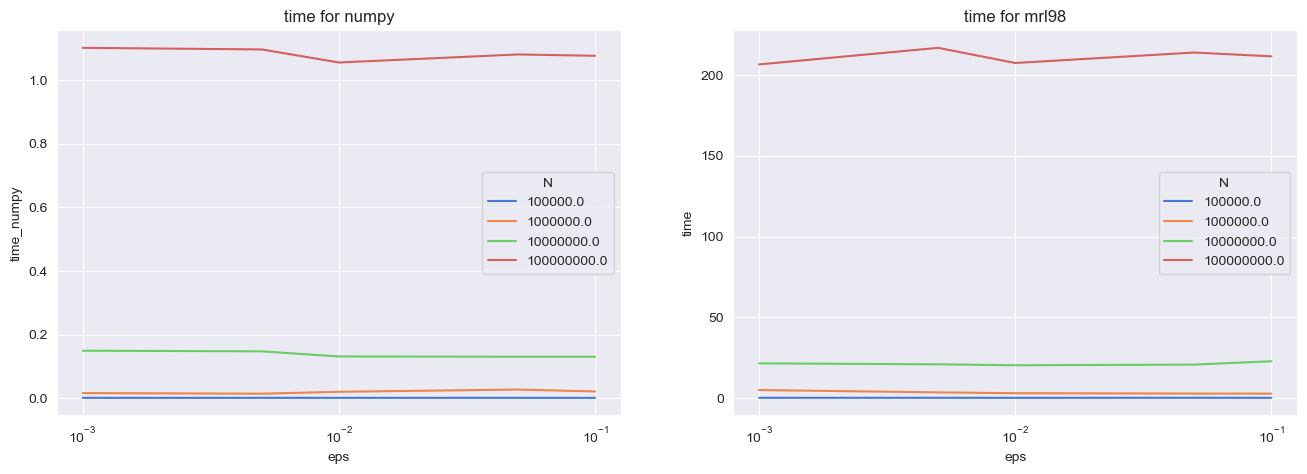

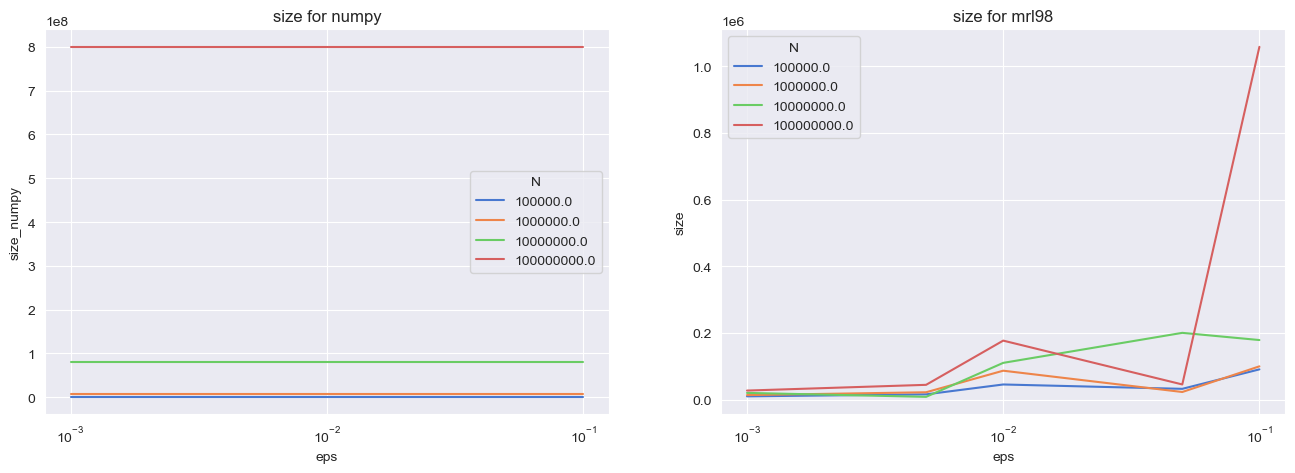

,q_numpy,q_mrl98,eps,N
0,5.002658,5.071479,0.001,100000.0
1,5.002658,5.106974,0.005,100000.0
2,5.002658,4.993610,0.010,100000.0
3,5.002658,5.035501,0.050,100000.0
4,5.002658,5.003014,0.100,100000.0
5,4.998908,5.115801,0.001,1000000.0
6,4.998908,5.043360,0.005,1000000.0
7,4.998908,4.994382,0.010,1000000.0
8,4.998908,5.000685,0.050,1000000.0
9,4.998908,5.037905,0.100,1000000.0


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.lineplot(x="eps", y="time_numpy", hue="N", data=df, palette="muted", ax=ax[0])
plt.xlabel('eps')
plt.ylabel('time')
ax[0].set(title='time for numpy',xticks=epsArray, xticklabels=epsArray, xscale='log')

sns.lineplot(x="eps", y="time_mrl98", hue="N", data=df, palette="muted", ax=ax[1])
plt.xlabel('eps')
plt.ylabel('time')
ax[1].set(title='time for mrl98',xticks=epsArray, xticklabels=epsArray, xscale='log')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(x="eps", y="size_numpy", hue="N", data=df, palette="muted", ax=ax[0])
plt.xlabel('eps')
plt.ylabel('size')
ax[0].set(title='size for numpy',xticks=epsArray, xticklabels=epsArray, xscale='log')

sns.lineplot(x="eps", y="size_mrl98", hue="N", data=df, palette="muted", ax=ax[1])
plt.xlabel('eps')
plt.ylabel('size')
ax[1].set(title='size for mrl98',xticks=epsArray, xticklabels=epsArray, xscale='log')
plt.show()

df[['q_numpy', 'q_mrl98', 'eps', 'N']]

#### Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution.

In [6]:
# inverse cdf of the normal distribution
from scipy.stats import norm
from statistics import NormalDist
df = df[['q_mrl98', 'eps']]

quantile_mrl_98 = df.loc[df['eps'] == 0.001, 'q_mrl98'].tolist()
sizeOfStream = [100000, 1000000, 10000000, 100000000]
print(quantile_mrl_98)
quantile_inv_cdf = []
for size in range(4):
    numbers = random_samples_for_inv_cdf[size]
    quantile_inv_cdf.append(NormalDist.from_samples(numbers).inv_cdf(0.5))

print(quantile_inv_cdf)

[5.071479359519294, 5.115801486647474, 5.054870189432102, 4.940093869523012]
[5.003596931165031, 4.9990164221218265, 5.000561756063183, 5.000185001467206]


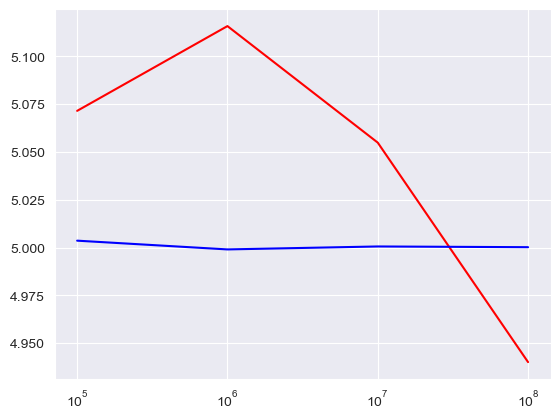

In [7]:
import matplotlib.pyplot as plt

plt.plot(sizeOfStream[:4], quantile_mrl_98, label='quantile_mrl_98', color='red')
plt.plot(sizeOfStream[:4], quantile_inv_cdf, label='quantile_inv_cdf', color='blue')
plt.xticks(sizeOfStream[:4])
plt.xscale('log')
plt.show()

## As you can see from the graph above:
> Somehow with increase in sample size, quantiles calculated with MRL98 algorithm diverge from the `inverse cdf` of the distribution.
> I think it might be because we are using values for MRL98 algorithm from the paper, and they might appear to be not optimal for our case.
> Nevertheless, until 10 to the power of 8 quantiles calculated with MRL98 algorithm are very close (tending to) to the `inverse cdf` of the distribution.

## Comparison with numPy

The main idea of the algorithm is to minimize amount of memory used. So, you need to compare the memory consumption of your algorithm with the memory consumption of the numpy algorithm (NumPy uses the whole stream of numbers for its algorithm, not buffers, so I decided that its' memory consumption will be the size of whole stream). It is easy to see by the graphs above that the memory used by numpy is significantly larger (800MB against 1MB). This is because numpy stores the entire array in memory, while our algorithm only stores the current window of size k. Unfortunately, there can be seen major diadvantages of our algorithm. The time it takes to compute the quantile is significantly larger than the time it takes for numpy.